<a href="https://colab.research.google.com/github/alphalyncis/adaa/blob/main/ml/workshop_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up: Run the following cell to configure our working directory appropriately.
If we are running on Google Colab, the following cell will clone the notebooks into our Colab filespace. If instead running locally, it will add the parent directory of the notebooks to the path such that we can import the custom module ```funcs```.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/harry-rendell/MLworkshop.git
    sys.path.append('./MLworkshop')
else:
    sys.path.append('..')

Cloning into 'MLworkshop'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 223 (delta 7), reused 11 (delta 4), pack-reused 203
Receiving objects: 100% (223/223), 1.69 MiB | 6.10 MiB/s, done.
Resolving deltas: 100% (108/108), done.


## Tips!
* In Google Colab you can pass your cursor over a function to see what it does.
* If instead you are running locally, you can use Shift+Tab while your cursor is in a function to see what it does.

# Introduction
---
We are going to build and train a convolutional neural network to classify the MNIST dataset. This dataset contains 60,000 training and 10,000 test images of handwritten digits from 0 to 9. It is a similar dataset to the one used in the first workshop but it is higher resolution, where the images are a 28x28 grid of pixel values. In this notebook we will investigate the following: 
1. Making and training a simple convolutional network to classify handwritten digits
2. Adjusting our network so we can take a look at how it classifies the images

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, Conv2DTranspose
# Custom imports
from funcs.plotting import plot_classifications, plot_training, plot_data, plot_latent_space

# Load in data
---

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/x_train.max() # Normalise data so pixel values are between 0 and 1
x_test = x_test/x_test.max()

# Add a new axis to the end. This axis is used to specifiy the RGB channel.
# Although this axis is unnecessary since we are working with grayscale images, it is required to keep the shapes consistent.
x_train = x_train[:,:,:,np.newaxis]
x_test  = x_test [:,:,:,np.newaxis]

input_shape = (28,28,1)
n_classes = 10

11490434/11490434 [==============================] - 1s 0us/step


# Plot the data
---
### Let's take a look at the dataset

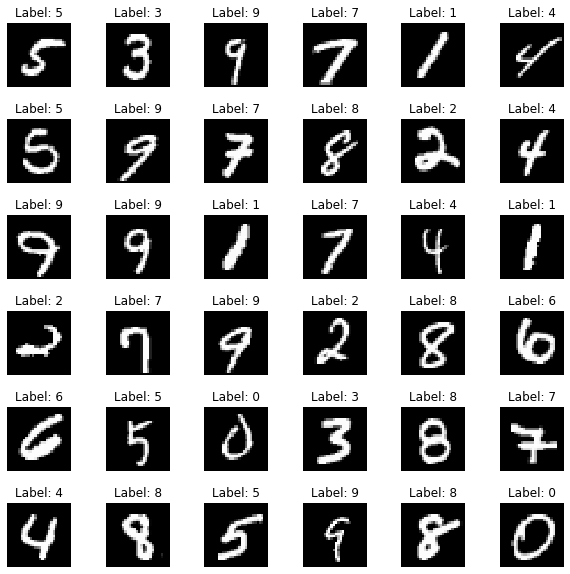

In [4]:
plot_data(x_train, y_train)

# Making your model
---
### This is the basic structure of constructing a convolutional neural network using Keras
> ```
> Line 1: i = Input(shape)
> Line 2: x = Conv2D(number_of_filters, kernel_size, activation)(i)
> Line 3: x = MaxPooling2D(pool_size)(x)
> Line 4: x = Conv2D(number_of_filters, kernel_size, activation)(x)
> ...
> Line 5: x = Flatten()(x)
> Line 6: o = Dense(n_classes, activation)(x)
>
> Line 7: mymodel = Model(i, o, name)
> Line 8: mymodel.summary()

* Line 1: We set the input of the model using the shape of our input. Since we are using 28x28 images in the training data, our input shape is (28,28). You can use the ```input_shape``` parameter defined earlier.
* Line 2: Here we create the first convolutional layer. We need to set the number of filters, kernel_size and activation.
* Line 3: Use the MaxPooling2D function which downsamples the image. We don't necessarily need this layer but it helps reduce the size of the network, and therefore speeds up training.
* Line 4: We can add more convolutional layers, provided we pass the previous layer to the new layer by putting (x) at the end as before. You may add as many Conv2D/MaxPooling2D layers as you wish after this. However, as both Conv2D/MaxPooling2D reduce the size of the image, you may get an error if you add too many because your output becomes too small!
* Line 5: Flatten the output from 2D to 1D so we can use a Dense layer next.
* Line 6: We need to finish with a Dense layer rather than a Conv2D layer because the output shape needs to be 1D to match the shape of the label data (y_train), which is also 1D. Also, we need to use an activation which gives a probability for how likely the given input is a particular number, a sensible choice would be activation='softmax' just like in workshop 1.
* Line 7: We construct the model using the ```Model()``` function. We pass the input and output as arguments. You can also name the model anything you like, e.g. name = 'My first model!'
* Line 8: Prints a summary of our model

In [15]:
### Use the template above to make your model here
number_of_filters = 50
kernel_size = (2,2)
pool_size = (2,2)
i = Input(shape=input_shape)
x = Conv2D(filters=number_of_filters, kernel_size=kernel_size, activation='relu')(i)
x = MaxPooling2D(pool_size)(x)
x = Flatten()(x)
o = Dense(n_classes, activation='softmax')(x)
mymodel = Model(i, o, name="Conv_network")
mymodel.summary()

Model: "Conv_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 50)        250       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8450)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                84510     
Total params: 84,760
Trainable params: 84,760
Non-trainable params: 0
_________________________________________________________________


# Training your model
---
### Now you have defined your model, use the template below to compile and train it.
> ```
> Line 9: mymodel.compile(...)
> Line 10: mymodel_history = mymodel.fit(...)


* Line 9: Here we compile the model using ```.compile()```. We need to pass the following arguments: 
    * optimizer='adam'
    * loss='sparse_categorical_crossentropy'
    * metrics='accuracy'


* Line 10: Train the model using ```.fit()```. We need to pass a few arguments here:
    * x - training images
    * y - training labels
    * epochs - how long to train for. ~10 is a good start.
    * batch_size - how many images to group up for each training step. ~128 is sensible.
    * validation_data - the test images and labels, ie (x_test, y_test).
    * verbose - Set this to True if you wish to see the progress of training. Otherwise set to False.
    
Note, you will need to rerun lines 1-10 if you wish to start training from scratch, as if you only run lines 9 & 10 it will continue where it left off.

In [19]:
### Use the template above to compile and train your model
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
mymodel_history = mymodel.fit(x=x_train, y=y_train, epochs=6, batch_size=128, validation_data=(x_test, y_test), verbose=True)

Epoch 1/6
469/469 [==============================] - 34s 71ms/step - loss: 0.0793 - accuracy: 0.9774 - val_loss: 0.0819 - val_accuracy: 0.9748
Epoch 2/6
469/469 [==============================] - 34s 73ms/step - loss: 0.0679 - accuracy: 0.9811 - val_loss: 0.0730 - val_accuracy: 0.9766
Epoch 3/6
469/469 [==============================] - 35s 74ms/step - loss: 0.0612 - accuracy: 0.9826 - val_loss: 0.0731 - val_accuracy: 0.9776
Epoch 4/6
469/469 [==============================] - 33s 71ms/step - loss: 0.0545 - accuracy: 0.9846 - val_loss: 0.0725 - val_accuracy: 0.9779
Epoch 5/6
469/469 [==============================] - 35s 74ms/step - loss: 0.0499 - accuracy: 0.9856 - val_loss: 0.0739 - val_accuracy: 0.9761
Epoch 6/6
469/469 [==============================] - 36s 77ms/step - loss: 0.0464 - accuracy: 0.9864 - val_loss: 0.0647 - val_accuracy: 0.9796


# Plot progress of training
---

### Now you have defined your model, use the template below to compile and train it.
> ```
> Line 11: plot_training(...)
> Line 12: mymodel.evaluate(...)


* Line 11: Pass the output from Line 9 to my custom function plot_training() to see how the training progressed over time.

* Line 12: Evaluate the model on the test data to find the final accuracy. Note that this function returns two numbers, loss and accuracy, but we are only interested in the accuracy at this point.

313/313 [==============================] - 3s 8ms/step - loss: 0.0647 - accuracy: 0.9796
Accuracy is: 0.9796000123023987


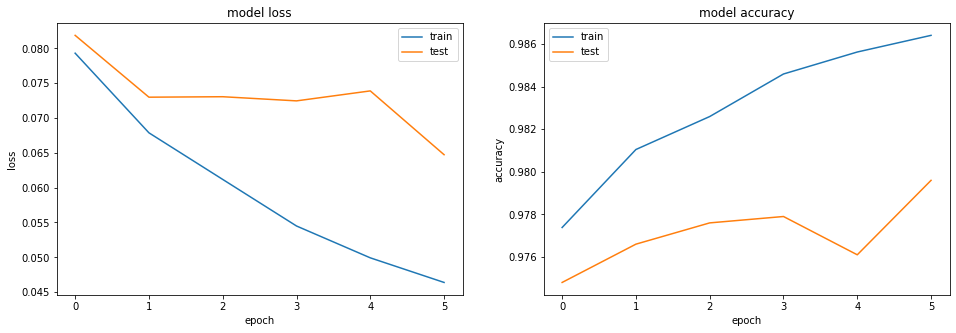

In [20]:
### Use the template above to plot the training and evaluate the test accuracy
plot_training(mymodel_history)
loss, accuracy = mymodel.evaluate(x_test, y_test)
print("Accuracy is:", accuracy)

# Plot classifications
---
### Let's plot some of the test data along with the predicted classifcations from the network.
> ```
> Line 13: predicted = mymodel.predict(x_test).argmax(axis=-1)
> Line 14: plot_classifications(x_test, y_test, predicted)


* Line 13: Ask the network to predict the labels of the test data. Then choose the one with the highest probability (argmax)

* Line 14: Use my custom function to plot a grid of test data with their true and predicted labels. Note, misclassifications will appear in red.

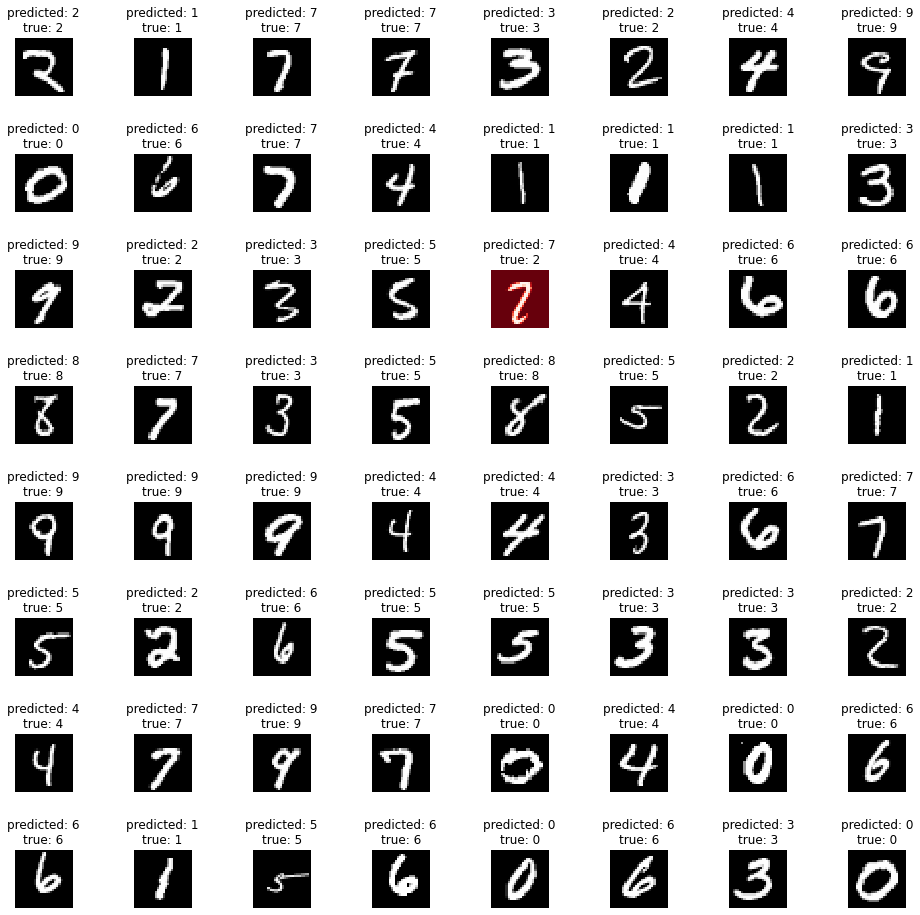

In [21]:
### Use the template above to predict and plot the classifications of the test data
predicted = mymodel.predict(x_test).argmax(axis=-1)
plot_classifications(x_test, y_test, predicted)

# Let's take a peek inside the network...
---
Neural networks are often consisdered 'Black Boxes' in the sense that it's incredibly hard to understand how the network is able to make the predictions it does. This is because there are thousands of connections between layers and it is not obvious which connections help classify ones and which classify sixes, for example.

However, if we introduce a small Dense layer with only 2 nodes (let's call this the bottle-neck layer), then we can look at the activations of these nodes when we pass different numbers through, and plot them on an x-y plane. Note, a network with a bottle-neck like this is called an autoencoder.

To make this network, copy your network from lines 1-10 but this time add a Dense layer with 2 nodes in between lines 5 and 6. Set the activation='None' (this is so that we can have negative outputs since relu only allows positive outputs).

You should find that your accuracy goes down when adding this bottle-neck. Why is this?

Model: "Conv_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 50)        250       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8450)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 16902     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                30        
Total params: 17,182
Trainable params: 17,182
Non-trainable params: 0
__________________________________________________

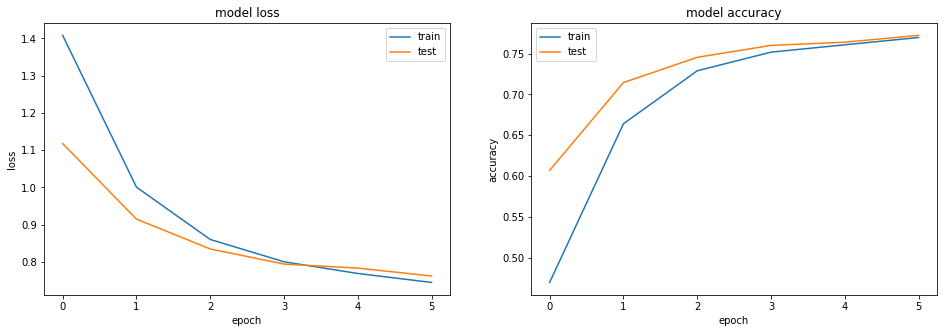

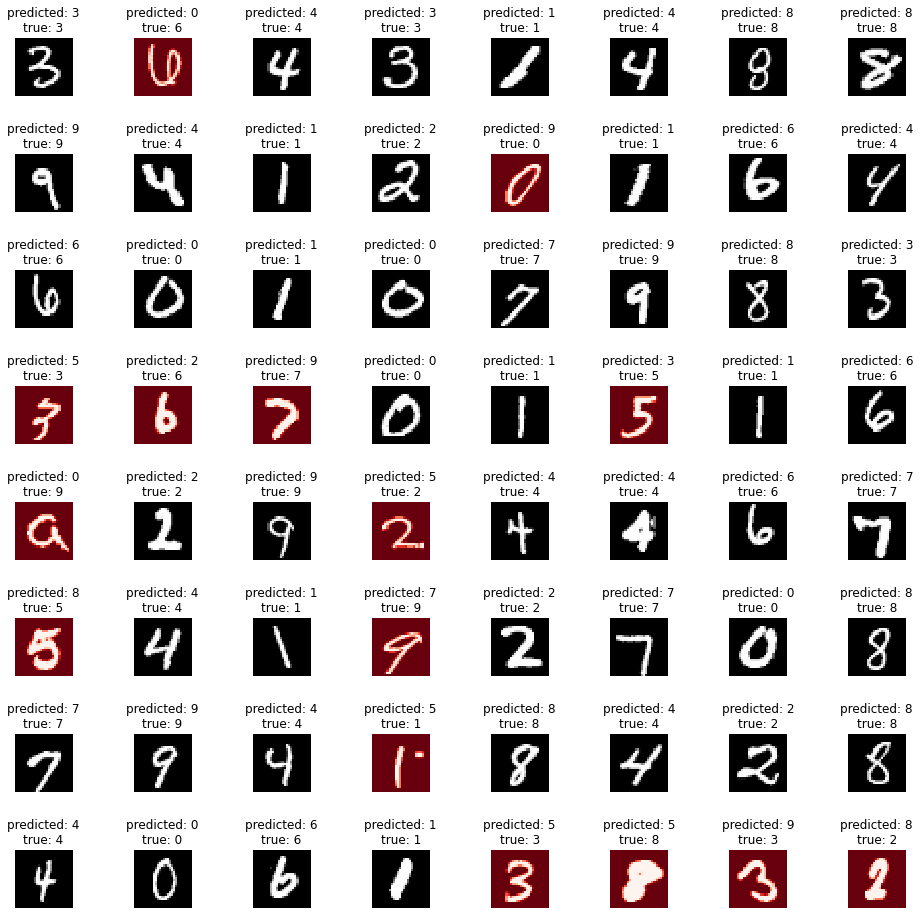

In [22]:
### Copy your code corresponding to lines 1-10, then add a Dense layer described above
number_of_filters = 50
kernel_size = (2,2)
pool_size = (2,2)
i = Input(shape=input_shape)
x = Conv2D(filters=number_of_filters, kernel_size=kernel_size, activation='relu')(i)
x = MaxPooling2D(pool_size)(x)
x = Flatten()(x)
x = Dense(2, activation=None)(x)
o = Dense(n_classes, activation='softmax')(x)
mymodel = Model(i, o, name="Conv_network")
mymodel.summary()
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
mymodel_history = mymodel.fit(x=x_train, y=y_train, epochs=6, batch_size=128, validation_data=(x_test, y_test), verbose=True)

plot_training(mymodel_history)
loss, accuracy = mymodel.evaluate(x_test, y_test)
print("Accuracy is:", accuracy)
predicted = mymodel.predict(x_test).argmax(axis=-1)
plot_classifications(x_test, y_test, predicted)

# Plotting the activations in the bottle-neck layer
---
### We will need to define a new model whose output is the Dense(2) layer of the previous model. We can do this using the following:
> ```
> Line 15: new_model = Model(inputs = mymodel.input, outputs = mymodel.layers[-2].output)
> Line 16: latent_output = new_model.predict(x_train)

Then we can plot using the following:

> ```
> Line 17: plot_latent_space(latent_output, y_train, n_classes)

Note, we don't need to retrain this new model as it will intiate in the same state as mymodel, which has already been trained!

Can you interpret this plot?

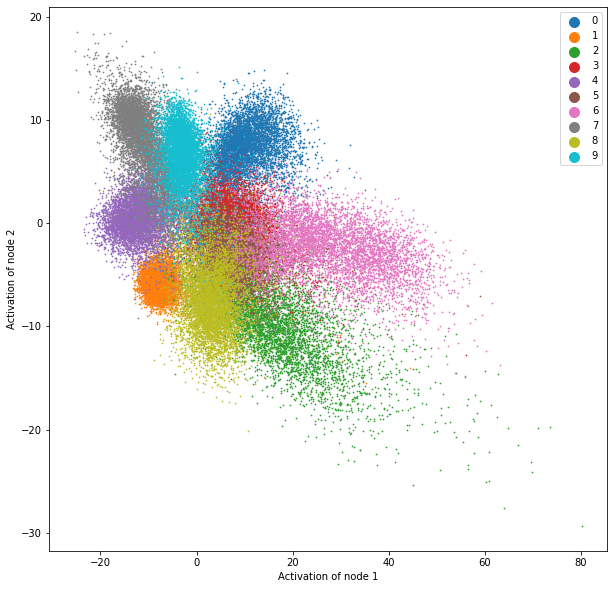

In [23]:
### Use the template above to define a new model, find the activations in the Dense(2) layer, and plot it.
new_model = Model(inputs = mymodel.input, outputs = mymodel.layers[-2].output)
latent_output = new_model.predict(x_train)
plot_latent_space(latent_output, y_train, n_classes)